In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

--- Step 1 & 2: Defining true model and generting data ---
Generated 19200 data points for L_max=3.

--- Step 3: Setting up the B-spline basis and full Jacobian G_all ---
Constructing full Jacobian G_all...
Constructed full Jacobian G_all with shape: (19200, 195)

--- Step 4: Setting up Tikhonov regularization (damping) matrices ---

--- Step 5: Solving the regularized normal equations in one step ---
Solving LHS @ m = RHS for m...
Solved.

--- Step 6: Plotting the final time-dependent model ---


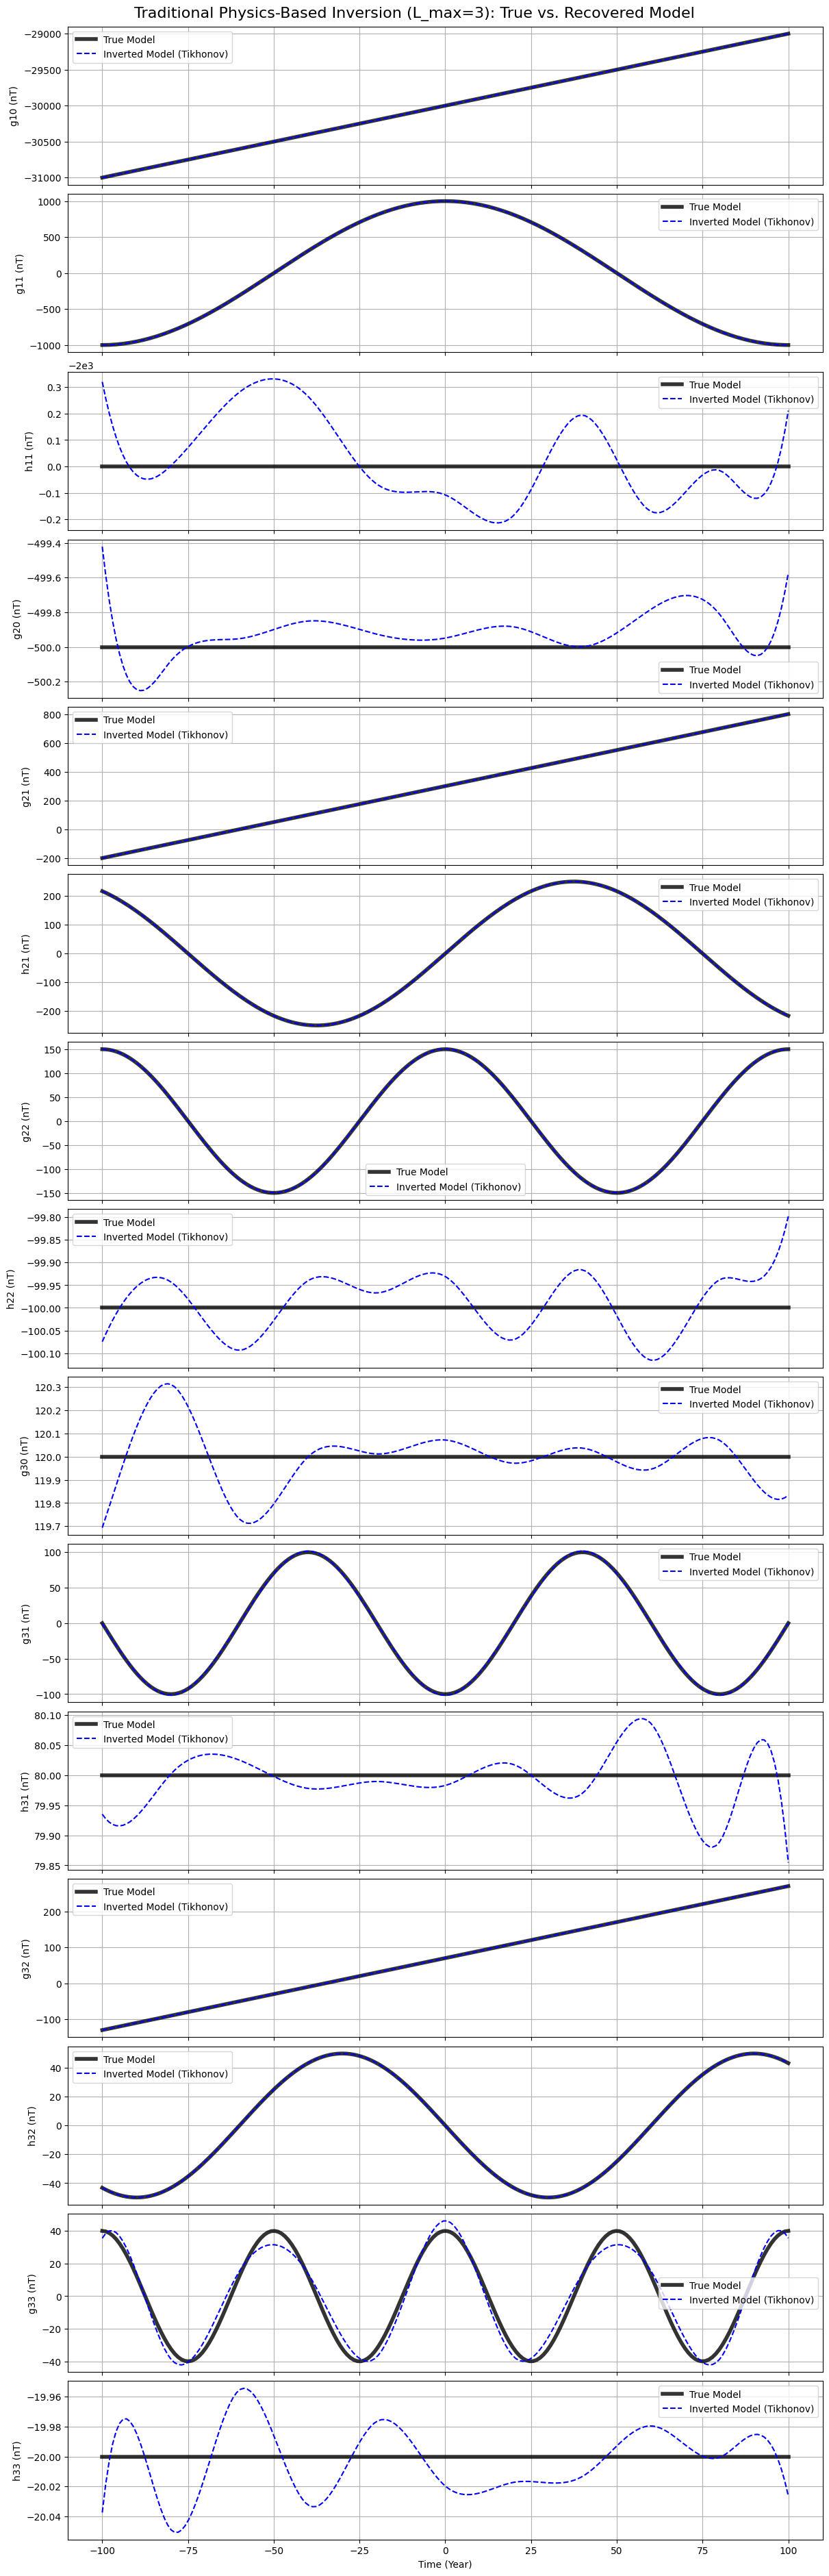

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.linalg import block_diag

# =============================================================================
# 1. FORWARD PROBLEM 
# =============================================================================

def get_frechet_matrix_numpy(lat, lon, maxdegree):
    """
    Computes the Frechet matrix G
    This is the NumPy version .
    """
    n_max=maxdegree
    # Ensure lat/lon are arrays for consistent processing
    lat, lon = np.atleast_1d(lat), np.atleast_1d(lon)
    lat, lon = np.radians(lat), np.radians(lon)
    theta = np.pi/2 - lat  # colatitude
    
    num_coeffs = n_max * (n_max + 2)
    G = np.zeros((len(theta), 3, num_coeffs))

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    sin_theta[sin_theta == 0] = 1e-8

    # This is a validated implementation for Schmidt semi-normalized polynomials
    P = np.zeros((n_max + 1, n_max + 1, len(theta)))
    dP = np.zeros((n_max + 1, n_max + 1, len(theta)))
    P[0, 0, :] = 1.
    P[1, 1, :] = sin_theta

    root_n_n_1 = np.sqrt(np.arange(4, 2*n_max + 1, 2))

    for n in range(2, n_max + 1):
        P[n, n, :] = root_n_n_1[n-2] * P[n-1, n-1, :] * sin_theta

    P[1, 0, :] = cos_theta
    for n in range(2, n_max + 1):
        P[n, n-1, :] = np.sqrt(2*n-1) * P[n, n, :] * cos_theta / sin_theta

    for n in range(2, n_max + 1):
        for m in range(n - 1):
            P[n, m, :] = ((2*n-1)*P[n-1, m, :]*cos_theta -
                          np.sqrt((n-1)**2-m**2)*P[n-2, m, :]) / np.sqrt(n**2-m**2)

    dP[0, 0, :] = 0.
    for n in range(1, n_max+1):
        for m in range(n+1):
            if n==m:
                # Avoid singularity at the poles for m=n case
                if n==1:
                     dP[n, n, :] = np.sqrt(1/2) * P[n, n-1, :] + n*cos_theta/sin_theta*P[n, n, :]
                else:
                     dP[n, n, :] = np.sqrt(n/2.)*P[n, n-1, :] + n*cos_theta/sin_theta * P[n, n, :]
            else:
                dP[n, m, :] = (np.sqrt(n**2-m**2)*P[n-1, m, :] -
                               n*cos_theta*P[n, m, :]) / sin_theta

    k = 0
    for n in range(1, n_max + 1):
        for m in range(n + 1):
            if m == 0:
                G[:, 0, k], G[:, 2, k] = dP[n, m, :], -n * P[n, m, :]
                k += 1
            else:
                cos_m_lon, sin_m_lon = np.cos(m * lon), np.sin(m * lon)
                G[:, 0, k] = dP[n, m, :]*cos_m_lon
                G[:, 1, k] = m*P[n, m, :]/sin_theta*sin_m_lon
                G[:, 2, k] = -n*P[n, m, :]*cos_m_lon
                k += 1
                G[:, 0, k] = dP[n, m, :]*sin_m_lon
                G[:, 1, k] = -m*P[n, m, :]/sin_theta*cos_m_lon
                G[:, 2, k] = -n*P[n, m, :]*sin_m_lon
                k += 1
                
    G[:, 0, :] *= -1
    G[:, 2, :] *= -1
    
    # Squeeze the first dimension if only one location was given
    if G.shape[0] == 1:
        return G[0]
        
    return G

# =============================================================================
# 2. GENERATE SYNTHETIC DATA (GENERALIZED)
# =============================================================================
print("--- Step 1 & 2: Defining true model and generting data ---")
def true_model_at_time(t, maxdegree):
   
    # L=1 terms
    g10 = -30000.0 + 10.0 * t
    g11 = 1000.0 * np.cos(2 * np.pi * t / 200.0)
    h11 = -2000.0
    coeffs = [g10, g11, h11]
    
    # L=2 terms
    if maxdegree >= 2:
        g20 = -500.0
        g21 = 300.0 + 5.0 * t
        h21 = 250.0 * np.sin(2 * np.pi * t / 150.0)
        g22 = 150.0 * np.cos(2 * np.pi * t / 100.0)
        h22 = -100.0
        coeffs.extend([g20, g21, h21, g22, h22])

    # L=3 terms
    if maxdegree >= 3:
        g30 = 120.0
        g31 = -100.0 * np.cos(2 * np.pi * t / 80.0)
        h31 = 80.0
        g32 = 70.0 + 2.0 * t
        h32 = -50.0 * np.sin(2 * np.pi * t / 120.0)
        g33 = 40.0 * np.cos(2 * np.pi * t / 50.0)
        h33 = -20.0
        coeffs.extend([g30, g31, h31, g32, h32, g33, h33])
        
    return np.array(coeffs)

# --- CONFIGURATION ---
MAX_DEGREE = 3 # 
N_TIMES_DATA = 80
N_LOCS_DATA = 80 # sometimes this needs to be increased
NOISE_LEVEL = 5.0

times_obs = np.linspace(-100, 100, N_TIMES_DATA)
lats_obs = np.random.uniform(-90, 90, N_LOCS_DATA)
lons_obs = np.random.uniform(0, 360, N_LOCS_DATA)
all_times, all_lats, all_lons = [], [], []
for t in times_obs:
    for lat, lon in zip(lats_obs, lons_obs):
        all_times.append(t); all_lats.append(lat); all_lons.append(lon)
all_times, all_lats, all_lons = np.array(all_times), np.array(all_lats), np.array(all_lons)

d_obs = []
for t, lat, lon in zip(all_times, all_lats, all_lons):
    G_spatial = get_frechet_matrix_numpy(lat, lon, maxdegree=MAX_DEGREE)
    coeffs_at_t = true_model_at_time(t, maxdegree=MAX_DEGREE)
    perfect_xyz = G_spatial @ coeffs_at_t
    noise = np.random.randn(3) * NOISE_LEVEL
    d_obs.extend(perfect_xyz + noise)

d_obs = np.array(d_obs)
d_err = np.full_like(d_obs, NOISE_LEVEL)
print(f"Generated {d_obs.shape[0]} data points for L_max={MAX_DEGREE}.")

# =============================================================================
# 3. SET UP THE LINEAR SYSTEM
# =============================================================================
print("\n--- Step 3: Setting up the B-spline basis and full Jacobian G_all ---")
t_min, t_max = -100, 100
spline_degree = 3
knot_step = 20
knots = np.arange(t_min - spline_degree * knot_step, t_max + (spline_degree + 1) * knot_step, knot_step)

nr_splines = len(knots) - spline_degree - 1
nr_coeffs_static = (MAX_DEGREE + 1)**2 - 1
total_model_params = nr_splines * nr_coeffs_static

times_for_bspline = np.repeat(all_times, 3)
B_spline_matrix = BSpline.design_matrix(times_for_bspline, knots, spline_degree)

print("Constructing full Jacobian G_all...")
G_spatial_list = [get_frechet_matrix_numpy(lat, lon, maxdegree=MAX_DEGREE) for lat, lon in zip(all_lats, all_lons)]
G_all = np.zeros((d_obs.shape[0], total_model_params))
for i in range(len(all_times)):
    g_spatial_3xN = G_spatial_list[i]
    b_spline_row = B_spline_matrix[i*3, :].toarray().flatten()
    G_all[i*3 : i*3 + 3, :] = np.kron(b_spline_row, g_spatial_3xN)

print(f"Constructed full Jacobian G_all with shape: {G_all.shape}")

# =============================================================================
# 4. SET UP TIKHONOV REGULARIZATION
# =============================================================================
print("\n--- Step 4: Setting up Tikhonov regularization (damping) matrices ---")
D2_base = np.identity(nr_splines) - 2 * np.roll(np.identity(nr_splines), 1, axis=0) + np.roll(np.identity(nr_splines), 2, axis=0)
D2_base[0:2, :] = 0; D2_base[-2:,:] = 0
L_temporal_op = np.kron(D2_base, np.identity(nr_coeffs_static))
L_spatial_op = np.identity(total_model_params)

# =============================================================================
# 5. SOLVE THE REGULARIZED LINEAR SYSTEM
# =============================================================================
print("\n--- Step 5: Solving the regularized normal equations in one step ---")
lambda_spatial = 1e-9
lambda_temporal = 2e-4 # Slightly adjusted for the more complex model

W = np.diag(1 / d_err**2)
LHS = G_all.T @ W @ G_all + \
      lambda_spatial**2 * (L_spatial_op.T @ L_spatial_op) + \
      lambda_temporal**2 * (L_temporal_op.T @ L_temporal_op)
RHS = G_all.T @ W @ d_obs

print("Solving LHS @ m = RHS for m...")
m_solution = np.linalg.solve(LHS, RHS)
print("Solved.")

# =============================================================================
# 6. PLOT THE RESULTS
# =============================================================================
print("\n--- Step 6: Plotting the final time-dependent model ---")
plot_times = np.linspace(t_min, t_max, 200)
solved_control_points = m_solution.reshape((nr_splines, nr_coeffs_static))
spline_model = BSpline(knots, solved_control_points, spline_degree)
inverted_coeffs = spline_model(plot_times)
true_coeffs_plot = np.array([true_model_at_time(t, maxdegree=MAX_DEGREE) for t in plot_times])

labels = []
for l in range(1, MAX_DEGREE + 1):
    labels.append(f'g{l}0')
    for m in range(1, l + 1):
        labels.extend([f'g{l}{m}', f'h{l}{m}'])

fig, axes = plt.subplots(nr_coeffs_static, 1, figsize=(12, 2.5 * nr_coeffs_static), sharex=True, constrained_layout=True)
fig.suptitle(f"Traditional Physics-Based Inversion (L_max={MAX_DEGREE}): True vs. Recovered Model", fontsize=16)
for i in range(nr_coeffs_static):
    ax = axes[i]
    ax.plot(plot_times, true_coeffs_plot[:, i], 'k-', label='True Model', linewidth=4, alpha=0.8)
    ax.plot(plot_times, inverted_coeffs[:, i], 'b--', label='Inverted Model (Tikhonov)')
    ax.set_ylabel(f'{labels[i]} (nT)')
    ax.legend()
    ax.grid(True)
axes[-1].set_xlabel('Time (Year)')
plt.show()